In [1]:
import pandas as pd

In [63]:
TM = pd.read_excel('TM_Daily Turnover - 210810.xlsx', sheet_name='Raw')
TY = pd.read_excel('TY_Daily Turnover - 210810.xlsx', sheet_name='Raw')
YT = pd.read_excel('YT_Daily Turnover - 210810.xlsx', sheet_name='Raw')
data = pd.concat([TM, TY, YT]).reset_index(drop=True)

In [22]:
data.Truck.nunique()

90

In [29]:
ut = data.groupby('Truck').count().Ticket.sort_values(ascending=False)

In [30]:
ut.describe()

count    90.000000
mean      1.900000
std       1.132264
min       1.000000
25%       1.000000
50%       1.000000
75%       3.000000
max       6.000000
Name: Ticket, dtype: float64

<AxesSubplot:>

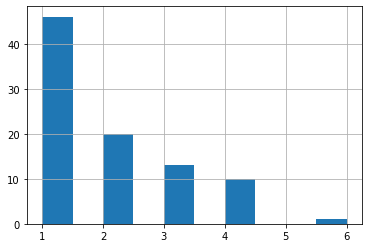

In [31]:
ut.hist()

## Schedule

In [211]:
from datetime import datetime, timedelta

DURATION = 4


def reschedule(TM, mode='fixed', duration=DURATION):
    if mode != 'fixed':
        sub = YT.groupby(['Truck', 'Time']).count().reset_index()[['Truck', 'Time']].copy()
        sub['Time'] = pd.to_datetime(sub['Time'])
        min_time = 1e8
        for s, subdf in sub.groupby('Truck'):
            subdf = subdf.sort_values('Time')
            time = (subdf['Time'] - subdf['Time'].shift(1)).min().total_seconds()
            min_time = time if time < min_time else min_time
        duration = min_time / 3600
        
        
    TM = TM[TM.Status != 'Cancelled']
    TM.Time = pd.to_datetime(TM.Time)
    bus_ls = list(TM.Truck.unique())


    schedule_ls = []
    queue = {}
    curr_truck = 1
    for i, row in TM.iterrows():
        if not bool(queue):
            curr_end = row.Time+timedelta(hours = duration)
            record = {'truck': curr_truck, 'start': row.Time, 'end': curr_end}
            schedule_ls.append(record)
            truck = curr_truck
            curr_truck += 1

        else:
            last_vacant_time, last_vacant_truck_ls = sorted(queue.items())[0]

            if last_vacant_time <= row.Time:
                curr_end = row.Time+timedelta(hours = duration)
                record = {'truck': last_vacant_truck_ls[0], 'start': row.Time, 'end': curr_end}
                schedule_ls.append(record)

                if len(last_vacant_truck_ls) == 1:
                    last_vacant_truck = last_vacant_truck_ls[0]
                    del(queue[last_vacant_time])
                else:
                    last_vacant_truck = last_vacant_truck_ls.pop(0)

                truck = last_vacant_truck

            else:
                curr_end = row.Time+timedelta(hours = duration)
                schedule_ls.append({'truck': curr_truck, 'start': row.Time, 'end': row.Time+timedelta(hours = duration)})
                truck = curr_truck
                curr_truck += 1

        if curr_end not in queue.keys():
            queue[curr_end] = [truck]
        else:
            queue[curr_end].append(truck)

    new = pd.DataFrame(schedule_ls)
    print('If setting turnover to be {} hrs, '.format(duration))
    print('Optimized num of trucks: ', new.truck.nunique())
    print('Actual num of trucks: ', len(bus_ls))
    print('=' * 30)
    if new.truck.nunique() < len(bus_ls):
        new['actual_truck'] = new['truck'].apply(lambda x: bus_ls[x-1])
    return new

In [212]:
new_TM = reschedule(TM, duration=DURATION)
new_TY = reschedule(TY, duration=DURATION)
new_YT = reschedule(YT, mode='flexible')

If setting turnover to be 4 hrs, 
Optimized num of trucks:  18
Actual num of trucks:  22
If setting turnover to be 4 hrs, 
Optimized num of trucks:  39
Actual num of trucks:  50
If setting turnover to be 0.6166666666666667 hrs, 
Optimized num of trucks:  9
Actual num of trucks:  22


/var/folders/tp/6gf539617v9fyg56c5hymktn_rsxrm/T/ipykernel_27256/3333045947.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TM.Time = pd.to_datetime(TM.Time)
/var/folders/tp/6gf539617v9fyg56c5hymktn_rsxrm/T/ipykernel_27256/3333045947.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TM.Time = pd.to_datetime(TM.Time)


In [214]:
new_TM

,truck,start,end,actual_truck
0,1,2022-12-21 08:03:00,2022-12-21 12:03:00,TT4762
1,2,2022-12-21 08:44:00,2022-12-21 12:44:00,PR6684
2,3,2022-12-21 08:45:00,2022-12-21 12:45:00,TN2360
3,4,2022-12-21 09:04:00,2022-12-21 13:04:00,TJ5319
4,5,2022-12-21 09:28:00,2022-12-21 13:28:00,SG3500
5,6,2022-12-21 09:51:00,2022-12-21 13:51:00,TZ991
6,7,2022-12-21 10:08:00,2022-12-21 14:08:00,SV309
7,8,2022-12-21 10:35:00,2022-12-21 14:35:00,JR5483
8,9,2022-12-21 10:54:00,2022-12-21 14:54:00,TR7159
9,10,2022-12-21 11:13:00,2022-12-21 15:13:00,UT7159


In [215]:
new_TY

,truck,start,end,actual_truck
0,1,2022-12-21 07:14:00,2022-12-21 11:14:00,RJ3047
1,2,2022-12-21 07:32:00,2022-12-21 11:32:00,VP5680
2,3,2022-12-21 08:04:00,2022-12-21 12:04:00,RY3305
3,4,2022-12-21 08:14:00,2022-12-21 12:14:00,VK9267
4,5,2022-12-21 08:24:00,2022-12-21 12:24:00,TH7353
...,...,...,...,...
61,23,2022-12-21 14:59:00,2022-12-21 18:59:00,TR5345
62,24,2022-12-21 15:13:00,2022-12-21 19:13:00,UW6992
63,25,2022-12-21 15:35:00,2022-12-21 19:35:00,WH5536
64,26,2022-12-21 15:55:00,2022-12-21 19:55:00,RU7960


In [216]:
new_YT

,truck,start,end,actual_truck
0,1,2022-12-21 07:47:00,2022-12-21 08:24:00,RE3007
1,2,2022-12-21 07:49:00,2022-12-21 08:26:00,TM8136
2,3,2022-12-21 07:54:00,2022-12-21 08:31:00,SF2942
3,1,2022-12-21 08:29:00,2022-12-21 09:06:00,RE3007
4,2,2022-12-21 08:38:00,2022-12-21 09:15:00,TM8136
...,...,...,...,...
65,4,2022-12-21 16:51:00,2022-12-21 17:28:00,XK5658
66,5,2022-12-21 17:47:00,2022-12-21 18:24:00,RE4295
67,6,2022-12-21 18:31:00,2022-12-21 19:08:00,PX1153
68,7,2022-12-21 18:47:00,2022-12-21 19:24:00,SG3111
